# About this notebook
- tokenizer(anchor[SEP]target | CPC)
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
comp_name = 'us-patent-phrase-to-phrase-matching'
nb_name = 'nb005t-deberta-v3-large'

import sys
print(sys.version)
if "google.colab" in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    base = f"/content/drive/MyDrive/colab_notebooks/kaggle/{comp_name}/notebooks"
    %cd {base}


import os
INPUT_DIR = f'../input/{comp_name}/'
if 'kaggle_web_client' in sys.modules:
    OUTPUT_DIR = './'
else:
    OUTPUT_DIR = f'../input/{nb_name}/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/colab_notebooks/kaggle/us-patent-phrase-to-phrase-matching/notebooks


# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    wandb=True
    wandbproject=comp_name
    wandbgroup=nb_name
    wandbname='late001'
    _wandb_kernel='riow1983'
    apex=True
    print_freq=100
    num_workers=8
    model="microsoft/deberta-v3-large"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=3
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    #### AWP
    adv_lr=1e-6
    adv_eps=1e-3
    #### AWPAWP
    n_fold=10
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]
    CFG.wandb = False

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    if 'google.colab' in sys.modules:
        !pip install wandb
    import wandb

    try:
        if 'kaggle_web_client' in sys.modules:
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
        else:
            import json
            f = open("../../wandb.json", "r")
            json_data = json.load(f)
            secret_value_0 = json_data["wandb_api"]
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))
    
    run = wandb.init(
        dir=OUTPUT_DIR,
        project=CFG.wandbproject,
        group=CFG.wandbgroup,
        name=CFG.wandbname, 
        config=class2dict(CFG),
        job_type="train",
        anonymous=anony)
    print(f"wandb run id: {run.id}")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: Currently logged in as: riow1983. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb run id: 1539wedu


# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


# # PyTorchのバージョンを1.10.1に下げる (Google Colabなのでpipでやる)
# os.system('pip uninstall -y torch torchvision torchaudio')
# os.system('pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html')


import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
# os.system('python -m pip install transformers')
# os.system('python -m pip install tokenizers')
os.system('pip install sentencepiece')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
# #### AUG
# # train = pd.read_csv(INPUT_DIR+'train.csv')
# train = pd.read_csv('../input/kagglenb006-back-translate-aug-data/train.csv')
# #### AUGAUG
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}

    # for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
    #     with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
    #         s = f.read()
    #     pattern = f'{cpc}\t\t.+'
    #     result = re.findall(pattern, s)
    #     cpc_result = result[0].lstrip(pattern)
    #     for context in [c for c in contexts if c[0] == cpc]:
    #         pattern = f'{context}\t\t.+'
    #         result = re.findall(pattern, s)
    #         results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    
    # Credits to https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/324928
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        pattern = "^"+pattern[:-2]
        cpc_result = re.sub(pattern, "", result[0])
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            pattern = "^"+pattern[:-2]
            results[context] = cpc_result + ". " + re.sub(pattern, "", result[0])

    
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
# train['text'] = train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
# test['text'] = test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']

#### SOL11
# train['text'] = train['anchor'] + '[SEP]' + train['target']
# test['text'] = test['anchor'] + '[SEP]' + test['target']

# train['text2'] = train['context_text']
# test['text2'] = test['context_text']

train['group'] = train['context'] + " " + train['anchor']
allres = {}
for text in tqdm(train["group"].unique()):
  tmpdf = train[train["group"]==text].reset_index(drop=True)
  texts = ",".join(tmpdf["target"])
  allres[text] = texts
train["target_gp"] = train["group"].map(allres)
train["text"] = train['anchor'] + "[SEP]" + train['target'] + "[SEP]" + train['context_text'] + "[SEP]" + train['target_gp']

test['group'] = test['context'] + " " + test['anchor']
allres = {}
for text in tqdm(test["group"].unique()):
  tmpdf = test[test["group"]==text].reset_index(drop=True)
  texts = ",".join(tmpdf["target"])
  allres[text] = texts
test["target_gp"] = test["group"].map(allres)
test["text"] = test['anchor'] + "[SEP]" + test['target'] + "[SEP]" + test['context_text'] + "[SEP]" + test['target_gp']
#### SOL11SOL11

display(train.head())
display(test.head())

  0%|          | 0/1699 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

,id,anchor,target,context,score,context_text,group,target_gp,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,A47 abatement,"abatement of pollution,act of abating,active c...",abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,group,target_gp,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,G02 opc drum,inorganic photoconductor drum,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,F23 adjust gas flow,altering gas flow,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,B60 lower trunnion,lower locating,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,D06 cap component,upper portion,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,H04 neural stimulation,artificial neural network,neural stimulation[SEP]artificial neural netwo...


# EDA

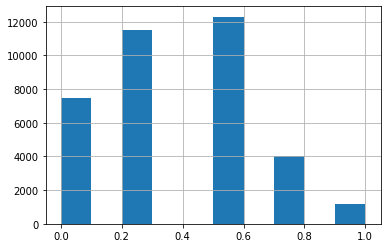

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())


# #### AUG
# aug = train[train['is_aug']==1].reset_index(drop=True)
# train = train[train['is_aug']==0].reset_index(drop=True)
# #### AUGAUG


# Credits to https://www.kaggle.com/code/hannes82/pppm-deberta-v3-large-closing-the-cv-lb-gap/notebook#CV-split
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
del dfx



# #### AUG
# res = []
# for fold in range(CFG.n_fold):
#     val_ids = train.loc[train['fold']==fold, 'id'].values
#     to_add_aug = aug[~aug['id'].isin(val_ids)].reset_index(drop=True)
#     to_add_aug['fold'] = fold+10
#     res.append(to_add_aug)

# to_add_aug = pd.concat(res, axis=0, ignore_index=True)
# train = pd.concat([train, to_add_aug], axis=0, ignore_index=True)
# del aug, to_add_aug, res, val_ids
# #### AUGAUG

print(train.fold.value_counts())

660 73
660 73
659 74
659 74
660 73
659 74
660 73
660 73
660 73
660 73
0    3954
9    3947
4    3902
6    3647
1    3634
3    3604
2    3524
5    3517
8    3487
7    3257
Name: fold, dtype: int64


In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

#### SOL11
# train["text"] = train['anchor'] + "[SEP]" + train['target'] + "[SEP]" + train['context_text'] + "[SEP]" + train['target_gp']
# for text_col in ['anchor', 'target']:
for text_col in ['anchor', 'target', 'target_gp']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
# CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
#                 + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP

CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + max(lengths_dict['target_gp']) + 5 # CLS + SEP + SEP + SEP + SEP

#### SOL11SOL11

# CFG.max_len = max(max(lengths_dict['anchor'])+max(lengths_dict['target'])+3, max(lengths_dict['context_text'])+2)
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 526


In [15]:
# ====================================================
# Dataset
# ====================================================

#### SOL11
# def prepare_input(cfg, text, text2):
#     inputs = cfg.tokenizer(text, text2,
#                            add_special_tokens=True,
#                            max_length=cfg.max_len,
#                            padding="max_length",
#                            return_offsets_mapping=False)
#     for k, v in inputs.items():
#         inputs[k] = torch.tensor(v, dtype=torch.long)
#     return inputs

def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs
#### SOL11SOL11


#### SOL11
# class TrainDataset(Dataset):
#     def __init__(self, cfg, df):
#         self.cfg = cfg
#         self.texts = df['text'].values
#         self.texts2 = df['text2'].values
#         self.labels = df['score'].values

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, item):
#         inputs = prepare_input(self.cfg, self.texts[item], self.texts2[item])
#         #inputs2 = prepare_input(self.cfg, self.texts2[item])
#         label = torch.tensor(self.labels[item], dtype=torch.float)
#         #return inputs, inputs2, label
#         return inputs, label

class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label
#### SOL11SOL11

In [16]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [17]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        
        # outputs2 = self.model(**inputs2)
        # last_hidden_states2 = outputs2[0]
        
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        #feature2 = torch.mean(last_hidden_states2, dim=1)
        #feature += feature2
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [18]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

#### AWP
#def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp):
#### AWPAWP
    model.train()
    # AWP
    #scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    # AWPAWP
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0

    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        #### AWP
        if score > 0.75:
            awp.attack_backward(inputs['input_ids'], labels, inputs['attention_mask'], step) 
        #### AWPAWP

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs2.items():
        #     inputs2[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        # for k, v in inputs[1].items():
        #     inputs[1][k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [19]:
#### AWP
class AWP:
    def __init__(
        self,
        model,
        optimizer,
        adv_param="weight",
        adv_lr=1,
        adv_eps=0.2,
        start_epoch=0,
        adv_step=1,
        scaler=None
    ):
        self.model = model
        self.optimizer = optimizer
        self.adv_param = adv_param
        self.adv_lr = adv_lr
        self.adv_eps = adv_eps
        self.start_epoch = start_epoch
        self.adv_step = adv_step
        self.backup = {}
        self.backup_eps = {}
        self.scaler = scaler

    def attack_backward(self, x, y, attention_mask,epoch):
        if (self.adv_lr == 0) or (epoch < self.start_epoch):
            return None

        self._save() 
        for i in range(self.adv_step):
            self._attack_step() 
            with torch.cuda.amp.autocast():
                adv_loss, tr_logits = self.model(input_ids=x, attention_mask=attention_mask, labels=y)
                adv_loss = adv_loss.mean()
            self.optimizer.zero_grad()
            self.scaler.scale(adv_loss).backward()
            
        self._restore()

    def _attack_step(self):
        e = 1e-6
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                norm1 = torch.norm(param.grad)
                norm2 = torch.norm(param.data.detach())
                if norm1 != 0 and not torch.isnan(norm1):
                    r_at = self.adv_lr * param.grad / (norm1 + e) * (norm2 + e)
                    param.data.add_(r_at)
                    param.data = torch.min(
                        torch.max(param.data, self.backup_eps[name][0]), self.backup_eps[name][1]
                    )
                # param.data.clamp_(*self.backup_eps[name])

    def _save(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None and self.adv_param in name:
                if name not in self.backup:
                    self.backup[name] = param.data.clone()
                    grad_eps = self.adv_eps * param.abs().detach()
                    self.backup_eps[name] = (
                        self.backup[name] - grad_eps,
                        self.backup[name] + grad_eps,
                    )

    def _restore(self,):
        for name, param in self.model.named_parameters():
            if name in self.backup:
                param.data = self.backup[name]
        self.backup = {}
        self.backup_eps = {}

#### AWPAWP

In [20]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    
    # #### AUG
    # train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    # train_folds_aug = train_folds[train_folds['fold']==fold+10].reset_index(drop=True)
    # train_folds_base = train_folds[train_folds['fold']<10].reset_index(drop=True)
    # train_folds = pd.concat([train_folds_base, train_folds_aug], axis=0, ignore_index=True)
    # del train_folds_aug, train_folds_base
    # #### AUGAUG
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)

    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    #### AWP
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    awp = AWP(model,
              optimizer,
              adv_lr=CFG.adv_lr,
              adv_eps=CFG.adv_eps,
              start_epoch=num_train_steps/CFG.epochs,
              scaler=scaler)
    score = 0.
    #### AWPAWP
    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        #### AWP
        #avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device, scaler, score, awp)
        #### AWPAWP

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()




    # Push to LINE
    import requests

    def send_line_notification(message):
        import json
        f = open("../../line.json", "r")
        json_data = json.load(f)
        line_token = json_data["kagglePush"]
        endpoint = 'https://notify-api.line.me/api/notify'
        message = "\n{}".format(message)
        payload = {'message': message}
        headers = {'Authorization': 'Bearer {}'.format(line_token)}
        requests.post(endpoint, data=payload, headers=headers)

    if CFG.wandb:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done. See {run.url}")
    else:
        send_line_notification(f"Training of {CFG.wandbproject+'/'+CFG.wandbgroup+'/'+CFG.wandbname} has been done.")

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/10839] Elapsed 0m 0s (remain 164m 1s) Loss: 0.7717(0.7717) Grad: inf  LR: 0.00002000  
Epoch: [1][100/10839] Elapsed 0m 35s (remain 63m 37s) Loss: 0.5814(0.6560) Grad: 25744.6348  LR: 0.00002000  
Epoch: [1][200/10839] Elapsed 1m 11s (remain 62m 53s) Loss: 0.7323(0.6523) Grad: 45217.1406  LR: 0.00002000  
Epoch: [1][300/10839] Elapsed 1m 46s (remain 62m 24s) Loss: 0.5192(0.6555) Grad: 40584.9570  LR: 0.00002000  
Epoch: [1][400/10839] Elapsed 2m 22s (remain 61m 53s) Loss: 0.6217(0.6544) Grad: 27413.5215  LR: 0.00002000  
Epoch: [1][500/10839] Elapsed 2m 58s (remain 61m 21s) Loss: 0.6631(0.6567) Grad: 15369.6914  LR: 0.00001999  
Epoch: [1][600/10839] Elapsed 3m 34s (remain 60m 45s) Loss: 0.7774(0.6578) Grad: 57672.5703  LR: 0.00001999  
Epoch: [1][700/10839] Elapsed 4m 9s (remain 60m 13s) Loss: 0.6077(0.6553) Grad: 96473.1406  LR: 0.00001999  
Epoch: [1][800/10839] Elapsed 4m 45s (remain 59m 37s) Loss: 0.5320(0.6524) Grad: 65171.7539  LR: 0.00001998  
Epoch: [1][900/10839]

Epoch 1 - avg_train_loss: 0.6305  avg_val_loss: 0.6601  time: 4043s
Epoch 1 - Score: 0.0022
Epoch 1 - Save Best Score: 0.0022 Model


EVAL: [1317/1318] Elapsed 4m 10s (remain 0m 0s) Loss: 0.8200(0.6601) 
Epoch: [2][0/10839] Elapsed 0m 0s (remain 151m 7s) Loss: 0.5185(0.5185) Grad: 68465.3984  LR: 0.00001707  
Epoch: [2][100/10839] Elapsed 0m 35s (remain 63m 44s) Loss: 0.6826(0.6550) Grad: 33909.0391  LR: 0.00001702  
Epoch: [2][200/10839] Elapsed 1m 10s (remain 62m 33s) Loss: 0.8382(0.6601) Grad: 84747.6484  LR: 0.00001697  
Epoch: [2][300/10839] Elapsed 1m 45s (remain 61m 43s) Loss: 0.5253(0.6634) Grad: 94203.0078  LR: 0.00001692  
Epoch: [2][400/10839] Elapsed 2m 20s (remain 61m 0s) Loss: 0.6792(0.6643) Grad: 16227.8779  LR: 0.00001686  
Epoch: [2][500/10839] Elapsed 2m 55s (remain 60m 21s) Loss: 0.6361(0.6619) Grad: 23942.8242  LR: 0.00001681  
Epoch: [2][600/10839] Elapsed 3m 30s (remain 59m 43s) Loss: 0.7058(0.6625) Grad: 41273.4727  LR: 0.00001676  
Epoch: [2][700/10839] Elapsed 4m 5s (remain 59m 10s) Loss: 0.4641(0.6602) Grad: 88438.0234  LR: 0.00001670  
Epoch: [2][800/10839] Elapsed 4m 40s (remain 58m 34s) L

Epoch 2 - avg_train_loss: 0.6560  avg_val_loss: 0.6569  time: 4011s
Epoch 2 - Score: 0.0048
Epoch 2 - Save Best Score: 0.0048 Model


EVAL: [1317/1318] Elapsed 4m 7s (remain 0m 0s) Loss: 0.8031(0.6569) 
Epoch: [3][0/10839] Elapsed 0m 0s (remain 145m 38s) Loss: 0.5555(0.5555) Grad: 35889.7539  LR: 0.00001000  
Epoch: [3][100/10839] Elapsed 0m 35s (remain 62m 34s) Loss: 0.5758(0.6580) Grad: 70409.7031  LR: 0.00000993  
Epoch: [3][200/10839] Elapsed 1m 9s (remain 61m 21s) Loss: 0.6784(0.6542) Grad: 26016.0156  LR: 0.00000986  
Epoch: [3][300/10839] Elapsed 1m 43s (remain 60m 33s) Loss: 0.6374(0.6571) Grad: 12325.4023  LR: 0.00000978  
Epoch: [3][400/10839] Elapsed 2m 17s (remain 59m 51s) Loss: 0.7818(0.6594) Grad: 52941.0586  LR: 0.00000971  
Epoch: [3][500/10839] Elapsed 2m 52s (remain 59m 12s) Loss: 0.6489(0.6584) Grad: 22366.9746  LR: 0.00000964  
Epoch: [3][600/10839] Elapsed 3m 26s (remain 58m 32s) Loss: 0.6911(0.6554) Grad: 25006.1680  LR: 0.00000957  
Epoch: [3][700/10839] Elapsed 4m 0s (remain 57m 58s) Loss: 0.4665(0.6544) Grad: 90221.0938  LR: 0.00000949  
Epoch: [3][800/10839] Elapsed 4m 34s (remain 57m 24s) L

Epoch 3 - avg_train_loss: 0.6553  avg_val_loss: 0.6565  time: 3942s
Epoch 3 - Score: 0.0048
Epoch 3 - Save Best Score: 0.0048 Model


EVAL: [1317/1318] Elapsed 4m 6s (remain 0m 0s) Loss: 0.8014(0.6565) 
Epoch: [4][0/10839] Elapsed 0m 0s (remain 145m 30s) Loss: 0.6371(0.6371) Grad: 7968.9531  LR: 0.00000293  
Epoch: [4][100/10839] Elapsed 0m 35s (remain 62m 20s) Loss: 0.5868(0.6609) Grad: 26270.2305  LR: 0.00000288  
Epoch: [4][200/10839] Elapsed 1m 9s (remain 61m 6s) Loss: 0.5732(0.6552) Grad: 21781.4453  LR: 0.00000283  
Epoch: [4][300/10839] Elapsed 1m 43s (remain 60m 16s) Loss: 0.7469(0.6529) Grad: 26377.2949  LR: 0.00000278  
Epoch: [4][400/10839] Elapsed 2m 17s (remain 59m 37s) Loss: 0.5206(0.6533) Grad: 38993.7070  LR: 0.00000273  
Epoch: [4][500/10839] Elapsed 2m 51s (remain 58m 57s) Loss: 0.6423(0.6521) Grad: 11254.1045  LR: 0.00000268  
Epoch: [4][600/10839] Elapsed 3m 25s (remain 58m 23s) Loss: 0.5264(0.6519) Grad: 21196.7422  LR: 0.00000263  
Epoch: [4][700/10839] Elapsed 3m 59s (remain 57m 48s) Loss: 0.6336(0.6536) Grad: 12496.1982  LR: 0.00000258  
Epoch: [4][800/10839] Elapsed 4m 33s (remain 57m 12s) Lo

Epoch 4 - avg_train_loss: 0.6551  avg_val_loss: 0.6561  time: 3937s
Epoch 4 - Score: 0.0026


EVAL: [1317/1318] Elapsed 4m 7s (remain 0m 0s) Loss: 0.7947(0.6561) 


========== fold: 0 result ==========
Score: 0.0048
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/10946] Elapsed 0m 0s (remain 154m 19s) Loss: 0.7533(0.7533) Grad: inf  LR: 0.00002000  
Epoch: [1][100/10946] Elapsed 0m 34s (remain 61m 15s) Loss: 0.8150(0.6741) Grad: 72420.3828  LR: 0.00002000  
Epoch: [1][200/10946] Elapsed 1m 7s (remain 60m 17s) Loss: 0.6134(0.6651) Grad: 35685.1367  LR: 0.00002000  
Epoch: [1][300/10946] Elapsed 1m 41s (remain 59m 34s) Loss: 0.7034(0.6654) Grad: 29143.5098  LR: 0.00002000  
Epoch: [1][400/10946] Elapsed 2m 14s (remain 58m 56s) Loss: 0.6819(0.6619) Grad: 47596.2656  LR: 0.00002000  
Epoch: [1][500/10946] Elapsed 2m 47s (remain 58m 18s) Loss: 0.4878(0.6559) Grad: 44043.5703  LR: 0.00001999  
Epoch: [1][600/10946] Elapsed 3m 21s (remain 57m 44s) Loss: 0.4650(0.6449) Grad: 67120.2891  LR: 0.00001999  
Epoch: [1][700/10946] Elapsed 3m 54s (remain 57m 10s) Loss: 0.3182(0.6397) Grad: 172768.4375  LR: 0.00001999  
Epoch: [1][800/10946] Elapsed 4m 28s (remain 56m 35s) Loss: 0.5663(0.6340) Grad: 101195.6016  LR: 0.00001998  
Epoch: [1][900/109

Epoch 1 - avg_train_loss: 0.5770  avg_val_loss: 0.5825  time: 3879s
Epoch 1 - Score: 0.7849
Epoch 1 - Save Best Score: 0.7849 Model


EVAL: [1211/1212] Elapsed 3m 36s (remain 0m 0s) Loss: 0.0021(0.5825) 
Epoch: [2][0/10946] Elapsed 0m 0s (remain 159m 59s) Loss: 0.4231(0.4231) Grad: 1075.6082  LR: 0.00001707  
Epoch: [2][100/10946] Elapsed 0m 34s (remain 62m 23s) Loss: 0.5727(0.5425) Grad: 7881.6758  LR: 0.00001702  
Epoch: [2][200/10946] Elapsed 1m 8s (remain 60m 55s) Loss: 0.5942(0.5610) Grad: 5524.9478  LR: 0.00001697  
Epoch: [2][300/10946] Elapsed 1m 41s (remain 59m 59s) Loss: 0.6575(0.5542) Grad: 2892.6553  LR: 0.00001692  
Epoch: [2][400/10946] Elapsed 2m 15s (remain 59m 19s) Loss: 0.4187(0.5387) Grad: 284.9771  LR: 0.00001686  
Epoch: [2][500/10946] Elapsed 2m 48s (remain 58m 39s) Loss: 0.6330(0.5390) Grad: 12427.8760  LR: 0.00001681  
Epoch: [2][600/10946] Elapsed 3m 22s (remain 58m 2s) Loss: 0.6204(0.5365) Grad: 9175.8496  LR: 0.00001676  
Epoch: [2][700/10946] Elapsed 3m 55s (remain 57m 27s) Loss: 0.6955(0.5396) Grad: 986.5988  LR: 0.00001671  
Epoch: [2][800/10946] Elapsed 4m 29s (remain 56m 54s) Loss: 0.6

Epoch 2 - avg_train_loss: 0.5407  avg_val_loss: 0.5710  time: 3887s
Epoch 2 - Score: 0.8255
Epoch 2 - Save Best Score: 0.8255 Model


EVAL: [1211/1212] Elapsed 3m 36s (remain 0m 0s) Loss: 0.0002(0.5710) 
Epoch: [3][0/10946] Elapsed 0m 0s (remain 157m 47s) Loss: 0.2939(0.2939) Grad: 7370.4180  LR: 0.00001000  
Epoch: [3][100/10946] Elapsed 0m 34s (remain 62m 9s) Loss: 0.7259(0.5335) Grad: 51937.6328  LR: 0.00000993  
Epoch: [3][200/10946] Elapsed 1m 8s (remain 61m 4s) Loss: 0.6506(0.5194) Grad: 13594.3330  LR: 0.00000986  
Epoch: [3][300/10946] Elapsed 1m 41s (remain 60m 7s) Loss: 0.4688(0.5123) Grad: 6555.2749  LR: 0.00000978  
Epoch: [3][400/10946] Elapsed 2m 15s (remain 59m 25s) Loss: 0.5016(0.5181) Grad: 55237.2461  LR: 0.00000971  
Epoch: [3][500/10946] Elapsed 2m 49s (remain 58m 45s) Loss: 0.6557(0.5154) Grad: 7089.2417  LR: 0.00000964  
Epoch: [3][600/10946] Elapsed 3m 22s (remain 58m 6s) Loss: 0.6898(0.5143) Grad: 5741.9233  LR: 0.00000957  
Epoch: [3][700/10946] Elapsed 3m 56s (remain 57m 29s) Loss: 0.6136(0.5147) Grad: 12538.8545  LR: 0.00000950  
Epoch: [3][800/10946] Elapsed 4m 29s (remain 56m 52s) Loss: 0

Epoch 3 - avg_train_loss: 0.5163  avg_val_loss: 0.5678  time: 3895s
Epoch 3 - Score: 0.8240


EVAL: [1211/1212] Elapsed 3m 37s (remain 0m 0s) Loss: 0.0000(0.5678) 
Epoch: [4][0/10946] Elapsed 0m 0s (remain 159m 13s) Loss: 0.3751(0.3751) Grad: 625.0587  LR: 0.00000293  
Epoch: [4][100/10946] Elapsed 0m 34s (remain 62m 0s) Loss: 0.4625(0.5119) Grad: 1568.4152  LR: 0.00000288  
Epoch: [4][200/10946] Elapsed 1m 8s (remain 60m 54s) Loss: 0.1878(0.5041) Grad: 982.4276  LR: 0.00000283  
Epoch: [4][300/10946] Elapsed 1m 42s (remain 60m 17s) Loss: 0.2311(0.5014) Grad: 48.1809  LR: 0.00000278  
Epoch: [4][400/10946] Elapsed 2m 15s (remain 59m 33s) Loss: 0.4185(0.5042) Grad: 221.1147  LR: 0.00000273  
Epoch: [4][500/10946] Elapsed 2m 49s (remain 58m 54s) Loss: 0.6061(0.5046) Grad: 660.5948  LR: 0.00000268  
Epoch: [4][600/10946] Elapsed 3m 23s (remain 58m 20s) Loss: 0.1873(0.4993) Grad: 77.2119  LR: 0.00000263  
Epoch: [4][700/10946] Elapsed 3m 57s (remain 57m 46s) Loss: 0.3748(0.5028) Grad: 424.6339  LR: 0.00000258  
Epoch: [4][800/10946] Elapsed 4m 30s (remain 57m 11s) Loss: 0.6500(0.50

Epoch 4 - avg_train_loss: 0.5018  avg_val_loss: 0.5864  time: 3909s
Epoch 4 - Score: 0.8226


EVAL: [1211/1212] Elapsed 3m 37s (remain 0m 0s) Loss: 0.0000(0.5864) 


========== fold: 1 result ==========
Score: 0.8255
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/10983] Elapsed 0m 0s (remain 156m 0s) Loss: 0.6081(0.6081) Grad: inf  LR: 0.00002000  
Epoch: [1][100/10983] Elapsed 0m 34s (remain 61m 45s) Loss: 0.6230(0.6573) Grad: 57688.7148  LR: 0.00002000  
Epoch: [1][200/10983] Elapsed 1m 8s (remain 60m 48s) Loss: 0.7548(0.6687) Grad: 80111.4219  LR: 0.00002000  
Epoch: [1][300/10983] Elapsed 1m 41s (remain 60m 9s) Loss: 0.5855(0.6681) Grad: 108795.8906  LR: 0.00002000  
Epoch: [1][400/10983] Elapsed 2m 15s (remain 59m 33s) Loss: 0.6977(0.6648) Grad: 37318.2578  LR: 0.00002000  
Epoch: [1][500/10983] Elapsed 2m 48s (remain 58m 54s) Loss: 0.6182(0.6637) Grad: 25564.5645  LR: 0.00001999  
Epoch: [1][600/10983] Elapsed 3m 22s (remain 58m 18s) Loss: 0.7476(0.6643) Grad: 30620.4980  LR: 0.00001999  
Epoch: [1][700/10983] Elapsed 3m 56s (remain 57m 44s) Loss: 0.6249(0.6644) Grad: 117278.9766  LR: 0.00001999  
Epoch: [1][800/10983] Elapsed 4m 29s (remain 57m 7s) Loss: 0.7175(0.6643) Grad: 36299.8594  LR: 0.00001998  
Epoch: [1][900/10983]

Epoch 1 - avg_train_loss: 0.6572  avg_val_loss: 0.6557  time: 3899s
Epoch 1 - Score: -0.0265


EVAL: [1174/1175] Elapsed 3m 29s (remain 0m 0s) Loss: 1.0427(0.6557) 
Epoch: [2][0/10983] Elapsed 0m 0s (remain 156m 21s) Loss: 0.7235(0.7235) Grad: 25695.3105  LR: 0.00001707  
Epoch: [2][100/10983] Elapsed 0m 34s (remain 62m 10s) Loss: 0.7880(0.6570) Grad: 60601.8438  LR: 0.00001702  
Epoch: [2][200/10983] Elapsed 1m 8s (remain 60m 58s) Loss: 0.5304(0.6522) Grad: 33009.0117  LR: 0.00001697  
Epoch: [2][300/10983] Elapsed 1m 41s (remain 60m 14s) Loss: 0.6204(0.6520) Grad: 54045.1758  LR: 0.00001692  
Epoch: [2][400/10983] Elapsed 2m 15s (remain 59m 34s) Loss: 0.6194(0.6504) Grad: 32756.5234  LR: 0.00001687  
Epoch: [2][500/10983] Elapsed 2m 48s (remain 58m 53s) Loss: 0.6305(0.6504) Grad: 11545.9209  LR: 0.00001681  
Epoch: [2][600/10983] Elapsed 3m 22s (remain 58m 17s) Loss: 0.6089(0.6527) Grad: 77970.3594  LR: 0.00001676  
Epoch: [2][700/10983] Elapsed 3m 55s (remain 57m 40s) Loss: 0.5868(0.6522) Grad: 41992.9531  LR: 0.00001671  
Epoch: [2][800/10983] Elapsed 4m 29s (remain 57m 4s) 

Epoch 2 - avg_train_loss: 0.6560  avg_val_loss: 0.6571  time: 3901s
Epoch 2 - Score: -0.0304


EVAL: [1174/1175] Elapsed 3m 29s (remain 0m 0s) Loss: 1.1119(0.6571) 
Epoch: [3][0/10983] Elapsed 0m 0s (remain 161m 50s) Loss: 0.6438(0.6438) Grad: 13945.2480  LR: 0.00001000  
Epoch: [3][100/10983] Elapsed 0m 34s (remain 62m 5s) Loss: 0.6905(0.6435) Grad: 47197.0859  LR: 0.00000993  
Epoch: [3][200/10983] Elapsed 1m 8s (remain 61m 14s) Loss: 0.6226(0.6520) Grad: 13746.8076  LR: 0.00000986  
Epoch: [3][300/10983] Elapsed 1m 42s (remain 60m 34s) Loss: 0.6348(0.6527) Grad: 13154.2803  LR: 0.00000978  
Epoch: [3][400/10983] Elapsed 2m 16s (remain 59m 50s) Loss: 0.6788(0.6566) Grad: 26111.4785  LR: 0.00000971  
Epoch: [3][500/10983] Elapsed 2m 49s (remain 59m 8s) Loss: 0.7758(0.6568) Grad: 47142.0625  LR: 0.00000964  
Epoch: [3][600/10983] Elapsed 3m 23s (remain 58m 30s) Loss: 0.6310(0.6567) Grad: 12549.9121  LR: 0.00000957  
Epoch: [3][700/10983] Elapsed 3m 56s (remain 57m 54s) Loss: 0.5910(0.6561) Grad: 31562.9980  LR: 0.00000950  
Epoch: [3][800/10983] Elapsed 4m 30s (remain 57m 20s) L

Epoch 3 - avg_train_loss: 0.6553  avg_val_loss: 0.6561  time: 3904s
Epoch 3 - Score: -0.0307


EVAL: [1174/1175] Elapsed 3m 29s (remain 0m 0s) Loss: 1.0839(0.6561) 
Epoch: [4][0/10983] Elapsed 0m 0s (remain 156m 12s) Loss: 0.7369(0.7369) Grad: 29391.4805  LR: 0.00000293  
Epoch: [4][100/10983] Elapsed 0m 34s (remain 61m 55s) Loss: 0.7180(0.6521) Grad: 59070.7031  LR: 0.00000288  
Epoch: [4][200/10983] Elapsed 1m 8s (remain 61m 0s) Loss: 0.6417(0.6487) Grad: 38726.7930  LR: 0.00000283  
Epoch: [4][300/10983] Elapsed 1m 42s (remain 60m 23s) Loss: 0.6347(0.6481) Grad: 10154.9336  LR: 0.00000278  
Epoch: [4][400/10983] Elapsed 2m 15s (remain 59m 38s) Loss: 0.6884(0.6521) Grad: 22642.1426  LR: 0.00000273  
Epoch: [4][500/10983] Elapsed 2m 49s (remain 59m 2s) Loss: 0.6948(0.6554) Grad: 20004.0977  LR: 0.00000268  
Epoch: [4][600/10983] Elapsed 3m 23s (remain 58m 28s) Loss: 0.6837(0.6569) Grad: 15562.7744  LR: 0.00000263  
Epoch: [4][700/10983] Elapsed 3m 56s (remain 57m 54s) Loss: 0.5661(0.6562) Grad: 55756.8086  LR: 0.00000258  
Epoch: [4][800/10983] Elapsed 4m 30s (remain 57m 18s) L

Epoch 4 - avg_train_loss: 0.6551  avg_val_loss: 0.6560  time: 3901s
Epoch 4 - Score: -0.0297


EVAL: [1174/1175] Elapsed 3m 29s (remain 0m 0s) Loss: 1.0814(0.6560) 


========== fold: 2 result ==========
Score: 0.8287
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/10956] Elapsed 0m 0s (remain 144m 8s) Loss: 0.8223(0.8223) Grad: inf  LR: 0.00002000  
Epoch: [1][100/10956] Elapsed 0m 34s (remain 61m 15s) Loss: 0.6199(0.6801) Grad: 62452.3789  LR: 0.00002000  
Epoch: [1][200/10956] Elapsed 1m 7s (remain 60m 20s) Loss: 0.6925(0.6766) Grad: 46162.1602  LR: 0.00002000  
Epoch: [1][300/10956] Elapsed 1m 41s (remain 59m 37s) Loss: 0.6276(0.6695) Grad: 10924.1367  LR: 0.00002000  
Epoch: [1][400/10956] Elapsed 2m 14s (remain 58m 59s) Loss: 0.8055(0.6676) Grad: 26824.4512  LR: 0.00002000  
Epoch: [1][500/10956] Elapsed 2m 47s (remain 58m 25s) Loss: 0.6963(0.6638) Grad: 14250.3594  LR: 0.00001999  
Epoch: [1][600/10956] Elapsed 3m 21s (remain 57m 50s) Loss: 0.7726(0.6648) Grad: 30149.7285  LR: 0.00001999  
Epoch: [1][700/10956] Elapsed 3m 54s (remain 57m 16s) Loss: 0.7127(0.6631) Grad: 25162.5000  LR: 0.00001999  
Epoch: [1][800/10956] Elapsed 4m 28s (remain 56m 41s) Loss: 0.6139(0.6616) Grad: 4321.0601  LR: 0.00001998  
Epoch: [1][900/10956] 

Epoch 1 - avg_train_loss: 0.6531  avg_val_loss: 0.6570  time: 3890s
Epoch 1 - Score: 0.0308
Epoch 1 - Save Best Score: 0.0308 Model


Epoch: [2][0/10956] Elapsed 0m 0s (remain 157m 1s) Loss: 0.6890(0.6890) Grad: 19650.6367  LR: 0.00001707  
Epoch: [2][100/10956] Elapsed 0m 35s (remain 63m 5s) Loss: 0.6590(0.6602) Grad: 50135.4688  LR: 0.00001702  
Epoch: [2][200/10956] Elapsed 1m 8s (remain 61m 30s) Loss: 0.5663(0.6578) Grad: 10961.4443  LR: 0.00001697  
Epoch: [2][300/10956] Elapsed 1m 42s (remain 60m 31s) Loss: 0.6470(0.6618) Grad: 19119.1699  LR: 0.00001692  
Epoch: [2][400/10956] Elapsed 2m 16s (remain 59m 42s) Loss: 0.6281(0.6587) Grad: 10039.3379  LR: 0.00001687  
Epoch: [2][500/10956] Elapsed 2m 49s (remain 59m 2s) Loss: 0.8200(0.6573) Grad: 38778.0820  LR: 0.00001681  
Epoch: [2][600/10956] Elapsed 3m 23s (remain 58m 21s) Loss: 0.6936(0.6591) Grad: 20741.4277  LR: 0.00001676  
Epoch: [2][700/10956] Elapsed 3m 56s (remain 57m 44s) Loss: 0.5885(0.6573) Grad: 31065.4941  LR: 0.00001671  
Epoch: [2][800/10956] Elapsed 4m 30s (remain 57m 8s) Loss: 0.6850(0.6564) Grad: 21008.1523  LR: 0.00001665  
Epoch: [2][900/10

Epoch 2 - avg_train_loss: 0.6559  avg_val_loss: 0.6601  time: 3890s
Epoch 2 - Score: -0.0206


Epoch: [3][0/10956] Elapsed 0m 0s (remain 158m 41s) Loss: 0.6383(0.6383) Grad: 20265.7520  LR: 0.00001000  
Epoch: [3][100/10956] Elapsed 0m 34s (remain 61m 51s) Loss: 0.7131(0.6387) Grad: 32993.8984  LR: 0.00000993  
Epoch: [3][200/10956] Elapsed 1m 8s (remain 60m 49s) Loss: 0.5830(0.6452) Grad: 34284.5742  LR: 0.00000986  
Epoch: [3][300/10956] Elapsed 1m 42s (remain 60m 11s) Loss: 0.6637(0.6516) Grad: 31411.8945  LR: 0.00000978  
Epoch: [3][400/10956] Elapsed 2m 15s (remain 59m 31s) Loss: 0.6468(0.6527) Grad: 25837.2129  LR: 0.00000971  
Epoch: [3][500/10956] Elapsed 2m 49s (remain 58m 54s) Loss: 0.5223(0.6512) Grad: 49245.9688  LR: 0.00000964  
Epoch: [3][600/10956] Elapsed 3m 23s (remain 58m 18s) Loss: 0.6281(0.6515) Grad: 16746.3984  LR: 0.00000957  
Epoch: [3][700/10956] Elapsed 3m 56s (remain 57m 41s) Loss: 0.5314(0.6520) Grad: 38044.6406  LR: 0.00000950  
Epoch: [3][800/10956] Elapsed 4m 30s (remain 57m 4s) Loss: 0.7027(0.6508) Grad: 15507.8438  LR: 0.00000943  
Epoch: [3][900

Epoch 3 - avg_train_loss: 0.6554  avg_val_loss: 0.6578  time: 3902s
Epoch 3 - Score: 0.0263


Epoch: [4][0/10956] Elapsed 0m 0s (remain 161m 26s) Loss: 0.7382(0.7382) Grad: 32753.5801  LR: 0.00000293  
Epoch: [4][100/10956] Elapsed 0m 34s (remain 61m 48s) Loss: 0.4972(0.6532) Grad: 90663.7656  LR: 0.00000288  
Epoch: [4][200/10956] Elapsed 1m 8s (remain 60m 39s) Loss: 0.7965(0.6499) Grad: 62929.2188  LR: 0.00000283  
Epoch: [4][300/10956] Elapsed 1m 41s (remain 59m 52s) Loss: 0.5439(0.6508) Grad: 49889.6602  LR: 0.00000278  
Epoch: [4][400/10956] Elapsed 2m 15s (remain 59m 14s) Loss: 0.5403(0.6509) Grad: 42257.5312  LR: 0.00000273  
Epoch: [4][500/10956] Elapsed 2m 48s (remain 58m 38s) Loss: 0.7698(0.6520) Grad: 72509.3828  LR: 0.00000268  
Epoch: [4][600/10956] Elapsed 3m 22s (remain 58m 8s) Loss: 0.5922(0.6525) Grad: 31985.6133  LR: 0.00000263  
Epoch: [4][700/10956] Elapsed 3m 56s (remain 57m 34s) Loss: 0.6372(0.6515) Grad: 14666.0869  LR: 0.00000258  
Epoch: [4][800/10956] Elapsed 4m 29s (remain 56m 58s) Loss: 0.7419(0.6526) Grad: 53870.8984  LR: 0.00000254  
Epoch: [4][900

Epoch 4 - avg_train_loss: 0.6552  avg_val_loss: 0.6571  time: 3899s
Epoch 4 - Score: 0.0215
========== fold: 3 result ==========
Score: 0.0308
========== fold: 4 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from t

Epoch: [1][0/10857] Elapsed 0m 0s (remain 144m 15s) Loss: 0.7870(0.7870) Grad: inf  LR: 0.00002000  
Epoch: [1][100/10857] Elapsed 0m 34s (remain 60m 42s) Loss: 0.6954(0.6902) Grad: 41022.1602  LR: 0.00002000  
Epoch: [1][200/10857] Elapsed 1m 7s (remain 59m 48s) Loss: 0.3879(0.6717) Grad: 79736.4453  LR: 0.00002000  
Epoch: [1][300/10857] Elapsed 1m 41s (remain 59m 7s) Loss: 0.7604(0.6654) Grad: 95874.9297  LR: 0.00002000  
Epoch: [1][400/10857] Elapsed 2m 14s (remain 58m 31s) Loss: 0.8681(0.6625) Grad: 90093.6016  LR: 0.00002000  
Epoch: [1][500/10857] Elapsed 2m 48s (remain 57m 57s) Loss: 0.5813(0.6605) Grad: 23395.3594  LR: 0.00001999  
Epoch: [1][600/10857] Elapsed 3m 21s (remain 57m 22s) Loss: 0.6860(0.6603) Grad: 36968.8398  LR: 0.00001999  
Epoch: [1][700/10857] Elapsed 3m 55s (remain 56m 49s) Loss: 0.5590(0.6597) Grad: 36383.8203  LR: 0.00001999  
Epoch: [1][800/10857] Elapsed 4m 28s (remain 56m 16s) Loss: 0.7293(0.6593) Grad: 38679.0664  LR: 0.00001998  
Epoch: [1][900/10857]

Epoch 1 - avg_train_loss: 0.6573  avg_val_loss: 0.6544  time: 3897s
Epoch 1 - Score: -0.0425


EVAL: [1300/1301] Elapsed 3m 54s (remain 0m 0s) Loss: 0.6613(0.6544) 
Epoch: [2][0/10857] Elapsed 0m 0s (remain 156m 47s) Loss: 0.6735(0.6735) Grad: 13464.1416  LR: 0.00001707  
Epoch: [2][100/10857] Elapsed 0m 34s (remain 61m 29s) Loss: 0.5857(0.6613) Grad: 45112.0469  LR: 0.00001702  
Epoch: [2][200/10857] Elapsed 1m 8s (remain 60m 35s) Loss: 0.5438(0.6623) Grad: 35412.4180  LR: 0.00001697  
Epoch: [2][300/10857] Elapsed 1m 42s (remain 60m 1s) Loss: 0.6869(0.6609) Grad: 11893.1338  LR: 0.00001692  
Epoch: [2][400/10857] Elapsed 2m 16s (remain 59m 21s) Loss: 0.5347(0.6584) Grad: 60622.5820  LR: 0.00001686  
Epoch: [2][500/10857] Elapsed 2m 50s (remain 58m 42s) Loss: 0.9441(0.6581) Grad: 232434.5000  LR: 0.00001681  
Epoch: [2][600/10857] Elapsed 3m 24s (remain 58m 6s) Loss: 0.6375(0.6587) Grad: 31032.0234  LR: 0.00001676  
Epoch: [2][700/10857] Elapsed 3m 58s (remain 57m 29s) Loss: 0.6879(0.6586) Grad: 19145.0547  LR: 0.00001670  
Epoch: [2][800/10857] Elapsed 4m 32s (remain 56m 55s) 

Epoch 2 - avg_train_loss: 0.6557  avg_val_loss: 0.6525  time: 3893s
Epoch 2 - Score: -0.0332


EVAL: [1300/1301] Elapsed 3m 53s (remain 0m 0s) Loss: 0.6619(0.6525) 
Epoch: [3][0/10857] Elapsed 0m 0s (remain 156m 29s) Loss: 0.8925(0.8925) Grad: 71361.9375  LR: 0.00001000  
Epoch: [3][100/10857] Elapsed 0m 34s (remain 61m 19s) Loss: 0.7390(0.6360) Grad: 31086.1875  LR: 0.00000993  
Epoch: [3][200/10857] Elapsed 1m 8s (remain 60m 18s) Loss: 0.8143(0.6486) Grad: 37945.9336  LR: 0.00000985  
Epoch: [3][300/10857] Elapsed 1m 41s (remain 59m 35s) Loss: 0.5948(0.6462) Grad: 14910.3535  LR: 0.00000978  
Epoch: [3][400/10857] Elapsed 2m 15s (remain 58m 57s) Loss: 0.7620(0.6503) Grad: 20362.8477  LR: 0.00000971  
Epoch: [3][500/10857] Elapsed 2m 49s (remain 58m 21s) Loss: 0.6099(0.6547) Grad: 16610.8125  LR: 0.00000964  
Epoch: [3][600/10857] Elapsed 3m 23s (remain 57m 50s) Loss: 0.7265(0.6545) Grad: 13659.4854  LR: 0.00000957  
Epoch: [3][700/10857] Elapsed 3m 57s (remain 57m 14s) Loss: 0.6926(0.6564) Grad: 15428.6592  LR: 0.00000949  
Epoch: [3][800/10857] Elapsed 4m 30s (remain 56m 40s)

Epoch 3 - avg_train_loss: 0.6554  avg_val_loss: 0.6528  time: 3892s
Epoch 3 - Score: -0.0354


EVAL: [1300/1301] Elapsed 3m 52s (remain 0m 0s) Loss: 0.6634(0.6528) 
Epoch: [4][0/10857] Elapsed 0m 0s (remain 158m 18s) Loss: 0.6902(0.6902) Grad: 12644.5420  LR: 0.00000293  
Epoch: [4][100/10857] Elapsed 0m 34s (remain 61m 15s) Loss: 0.6854(0.6597) Grad: 30738.6191  LR: 0.00000288  
Epoch: [4][200/10857] Elapsed 1m 8s (remain 60m 17s) Loss: 0.5562(0.6498) Grad: 78292.7891  LR: 0.00000283  
Epoch: [4][300/10857] Elapsed 1m 42s (remain 59m 39s) Loss: 0.7414(0.6470) Grad: 32771.6523  LR: 0.00000278  
Epoch: [4][400/10857] Elapsed 2m 15s (remain 59m 5s) Loss: 0.7272(0.6519) Grad: 83682.4609  LR: 0.00000273  
Epoch: [4][500/10857] Elapsed 2m 49s (remain 58m 25s) Loss: 0.6842(0.6524) Grad: 14196.7812  LR: 0.00000268  
Epoch: [4][600/10857] Elapsed 3m 23s (remain 57m 51s) Loss: 0.6320(0.6521) Grad: 19810.5137  LR: 0.00000263  
Epoch: [4][700/10857] Elapsed 3m 57s (remain 57m 15s) Loss: 0.6367(0.6539) Grad: 14273.6377  LR: 0.00000258  
Epoch: [4][800/10857] Elapsed 4m 30s (remain 56m 40s) 

Epoch 4 - avg_train_loss: 0.6554  avg_val_loss: 0.6527  time: 3887s
Epoch 4 - Score: -0.0376


EVAL: [1300/1301] Elapsed 3m 51s (remain 0m 0s) Loss: 0.6629(0.6527) 


========== fold: 4 result ==========
Score: 0.8321
========== fold: 5 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/10985] Elapsed 0m 0s (remain 146m 26s) Loss: 0.5839(0.5839) Grad: inf  LR: 0.00002000  
Epoch: [1][100/10985] Elapsed 0m 34s (remain 61m 5s) Loss: 0.6562(0.6651) Grad: 28403.8945  LR: 0.00002000  
Epoch: [1][200/10985] Elapsed 1m 7s (remain 60m 14s) Loss: 0.5990(0.6603) Grad: 40457.8281  LR: 0.00002000  
Epoch: [1][300/10985] Elapsed 1m 40s (remain 59m 37s) Loss: 0.6944(0.6649) Grad: 59404.2070  LR: 0.00002000  
Epoch: [1][400/10985] Elapsed 2m 14s (remain 59m 1s) Loss: 0.4715(0.6617) Grad: 101461.8906  LR: 0.00002000  
Epoch: [1][500/10985] Elapsed 2m 47s (remain 58m 25s) Loss: 0.4817(0.6623) Grad: 102859.8516  LR: 0.00001999  
Epoch: [1][600/10985] Elapsed 3m 20s (remain 57m 49s) Loss: 0.5676(0.6633) Grad: 90096.4531  LR: 0.00001999  
Epoch: [1][700/10985] Elapsed 3m 54s (remain 57m 13s) Loss: 0.6173(0.6655) Grad: 70838.6094  LR: 0.00001999  
Epoch: [1][800/10985] Elapsed 4m 27s (remain 56m 37s) Loss: 0.7219(0.6657) Grad: 34343.0820  LR: 0.00001998  
Epoch: [1][900/10985